In [70]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
from tqdm import tqdm
from collections import Counter
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from sentence_transformers import SentenceTransformer, util

nltk.download('stopwords')

STOPWORDS = set(stopwords.words('english'))
STOPWORDS |= {
    "plant","plants","disease","diseases","crop","crops",
    "leaf","leaves","using","based","study","method"
}

plt.style.use("default")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [71]:
print("=== Literature Analysis Input ===")

QUERY = input("Enter search query (default: plant disease detection): ").strip()
if not QUERY:
    QUERY = "plant disease detection"

START_YEAR = input("Start year (default 2015): ").strip()
END_YEAR = input("End year (default 2025): ").strip()
N_TOPICS = input("Number of topics (default 8): ").strip()

START_YEAR = int(START_YEAR) if START_YEAR else 2015
END_YEAR = int(END_YEAR) if END_YEAR else 2025
N_TOPICS = int(N_TOPICS) if N_TOPICS else 8

print("\nSettings:")
print("Query:", QUERY)
print("Years:", START_YEAR, "-", END_YEAR)
print("Topics:", N_TOPICS)


=== Literature Analysis Input ===
Enter search query (default: plant disease detection): plant disease detection
Start year (default 2015): 2015
End year (default 2025): 2026
Number of topics (default 8): 8

Settings:
Query: plant disease detection
Years: 2015 - 2026
Topics: 8


In [72]:
print("\nEnter reference descriptions (one per line).")
print("These define what YOU consider relevant.")
print("Press ENTER on empty line to finish.\n")

REFERENCE_TEXTS = []
while True:
    line = input()
    if not line.strip():
        break
    REFERENCE_TEXTS.append(line.strip())

if not REFERENCE_TEXTS:
    REFERENCE_TEXTS = [
        "Plant disease detection using computer vision and deep learning"
    ]

print("\nReference descriptions:")
for i, r in enumerate(REFERENCE_TEXTS, 1):
    print(f"{i}. {r}")



Enter reference descriptions (one per line).
These define what YOU consider relevant.
Press ENTER on empty line to finish.



Reference descriptions:
1. Plant disease detection using computer vision and deep learning


In [73]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    tokens = [
        t for t in text.split()
        if t not in STOPWORDS and len(t) > 2
    ]
    return " ".join(tokens)


In [74]:
def fetch_openalex(query, max_pages=3, per_page=200):
    base = "https://api.openalex.org/works"
    papers = []

    for page in range(1, max_pages + 1):
        params = {
            "search": query,
            "per-page": per_page,
            "page": page
        }

        r = requests.get(base, params=params)
        if r.status_code != 200:
            break

        data = r.json()
        for item in data.get("results", []):
            papers.append({
                "title": item.get("display_name"),
                "abstract": item.get("abstract", ""),
                "year": item.get("publication_year"),
                "source": "OpenAlex"
            })

        time.sleep(1)

    return papers


In [75]:
def fetch_arxiv(query, max_results=200):
    import xml.etree.ElementTree as ET

    base = "http://export.arxiv.org/api/query"
    papers = []

    params = {
        "search_query": f"all:{query}",
        "start": 0,
        "max_results": max_results
    }

    r = requests.get(base, params=params)
    root = ET.fromstring(r.text)

    ns = {'atom': 'http://www.w3.org/2005/Atom'}
    for entry in root.findall('atom:entry', ns):
        year = entry.find('atom:published', ns).text[:4]
        papers.append({
            "title": entry.find('atom:title', ns).text,
            "abstract": entry.find('atom:summary', ns).text,
            "year": int(year),
            "source": "arXiv"
        })

    return papers


In [76]:
print("Fetching papers...")

papers = []
papers.extend(fetch_openalex(QUERY))
papers.extend(fetch_arxiv(QUERY))

df = pd.DataFrame(papers)
df.drop_duplicates(subset="title", inplace=True)

df = df[
    (df["year"] >= START_YEAR) &
    (df["year"] <= END_YEAR)
]

df["clean_abstract"] = df["abstract"].fillna("").apply(clean_text)

print("Total papers collected:", len(df))
df.head()


Fetching papers...
Total papers collected: 740


,title,abstract,year,source,clean_abstract
0,Using Deep Learning for Image-Based Plant Dise...,,2016,OpenAlex,
1,Deep learning models for plant disease detecti...,,2018,OpenAlex,
3,Plant Disease Detection Using Image Processing,,2015,OpenAlex,
4,Plant Disease Detection and Classification by ...,,2019,OpenAlex,
5,Plant Disease Detection and Classification by ...,,2021,OpenAlex,


In [77]:
model = SentenceTransformer("all-MiniLM-L6-v2")


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [78]:
# SAFETY CHECK (CRITICAL)
if not isinstance(REFERENCE_TEXTS, list) or len(REFERENCE_TEXTS) == 0:
    print("⚠️ No reference descriptions found.")
    print("Using default reference description.")
    REFERENCE_TEXTS = [
        "Plant disease detection using computer vision and deep learning"
    ]

# Pre-compute reference embeddings ONCE (important for speed & correctness)
ref_embs = model.encode(REFERENCE_TEXTS, convert_to_tensor=True)

def compute_relevance_score(title, abstract):
    text = f"{title}. {abstract}"

    # Encode paper
    paper_emb = model.encode(text, convert_to_tensor=True)

    # Cosine similarity
    scores = util.cos_sim(paper_emb, ref_embs)

    # Return highest similarity
    return float(scores.max())

# Apply safely
df["relevance_score"] = df.apply(
    lambda r: compute_relevance_score(
        str(r["title"]), str(r["abstract"])
    ),
    axis=1
)

print("Semantic relevance scoring completed.")


Semantic relevance scoring completed.


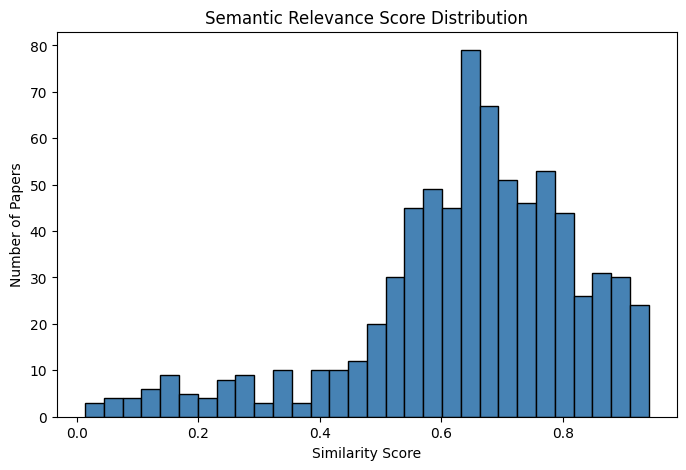

In [79]:
plt.figure(figsize=(8,5))
plt.hist(df["relevance_score"], bins=30, color="steelblue", edgecolor="black")
plt.title("Semantic Relevance Score Distribution")
plt.xlabel("Similarity Score")
plt.ylabel("Number of Papers")
plt.show()


In [80]:
try:
    THRESHOLD = input("\nEnter relevance threshold (default 0.45): ").strip()
    THRESHOLD = float(THRESHOLD) if THRESHOLD else 0.45
except Exception:
    THRESHOLD = 0.45

print("Using relevance threshold:", THRESHOLD)


df = df[df["relevance_score"] >= THRESHOLD]

print("Remaining papers after filtering:", len(df))
df.head()



Enter relevance threshold (default 0.45): 0.35
Using relevance threshold: 0.35
Remaining papers after filtering: 675


,title,abstract,year,source,clean_abstract,relevance_score
0,Using Deep Learning for Image-Based Plant Dise...,,2016,OpenAlex,,0.932679
1,Deep learning models for plant disease detecti...,,2018,OpenAlex,,0.903382
3,Plant Disease Detection Using Image Processing,,2015,OpenAlex,,0.750881
4,Plant Disease Detection and Classification by ...,,2019,OpenAlex,,0.933613
5,Plant Disease Detection and Classification by ...,,2021,OpenAlex,,0.906875


In [81]:
# SAFETY CHECK
if len(df) < 5:
    raise ValueError(
        "Not enough papers for topic modeling. "
        "Lower relevance threshold or broaden search query."
    )

vectorizer = TfidfVectorizer(
    max_df=0.9,
    min_df=2,          # LOWERED from 3 (important)
    ngram_range=(1,2),
    max_features=5000
)

X = vectorizer.fit_transform(df["clean_abstract"])

if X.shape[1] == 0:
    raise ValueError(
        "No features extracted. Try lowering min_df or cleaning rules."
    )

nmf = NMF(
    n_components=min(N_TOPICS, X.shape[0] - 1),
    random_state=42
)

W = nmf.fit_transform(X)
H = nmf.components_

df["topic"] = W.argmax(axis=1)

feature_names = vectorizer.get_feature_names_out()

print("\n=== Topics ===")
for i, topic in enumerate(H):
    words = [feature_names[j] for j in topic.argsort()[-10:][::-1]]
    print(f"Topic {i}: {', '.join(words)}")

print("\nTopic column successfully created.")



=== Topics ===
Topic 0: learning, detection, models, deep, deep learning, neural, various, accuracy, convolutional, research
Topic 1: images, diagnostic, data, training, performance, diagnostic performance, diagnosis, resolution, samples, target
Topic 2: ssl, supervised, self supervised, capture, self, lesion, learning, framework, state, teacher
Topic 3: detection, object, object detection, dataset, segmentation, new, precision, objects, oriented, natural
Topic 4: datasets, real, real world, performance, models, world, high, devices, shot, resource
Topic 5: model, proposed, classification, identification, accuracy, network, feature, rice, deep, images
Topic 6: tomato, late blight, blight, late, early, farmers, proposed, early detection, system, image
Topic 7: data, dataset, classifiers, detection, classification, vision, computer vision, computer, image, distribution

Topic column successfully created.


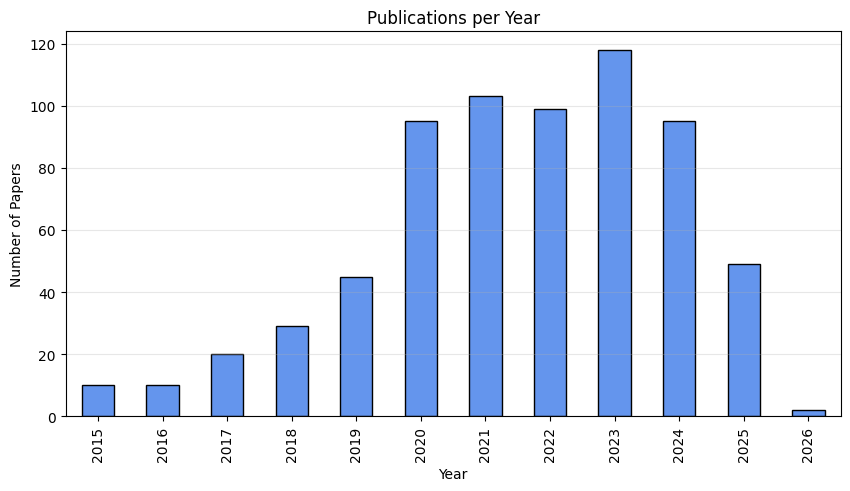

In [82]:
plt.figure(figsize=(10,5))
df["year"].value_counts().sort_index().plot(
    kind="bar",
    color="cornflowerblue",
    edgecolor="black"
)
plt.title("Publications per Year")
plt.xlabel("Year")
plt.ylabel("Number of Papers")
plt.grid(axis="y", alpha=0.3)
plt.show()


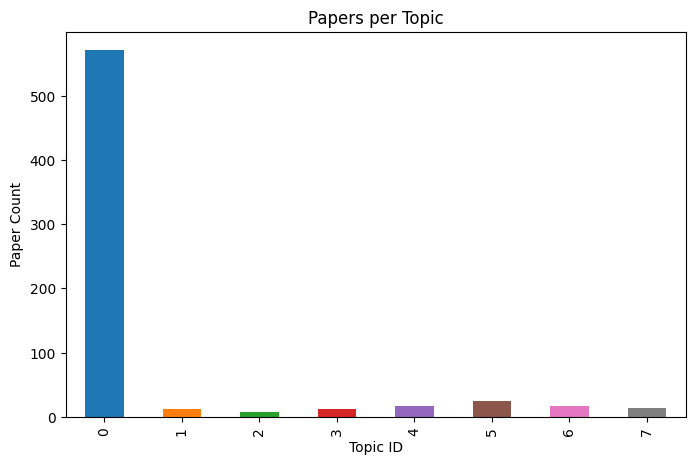

In [83]:
if "topic" not in df.columns:
    raise KeyError(
        "'topic' column not found. "
        "Run topic modeling cell before this."
    )

plt.figure(figsize=(8,5))
df["topic"].value_counts().sort_index().plot(
    kind="bar",
    color=plt.cm.tab10.colors
)
plt.title("Papers per Topic")
plt.xlabel("Topic ID")
plt.ylabel("Paper Count")
plt.show()


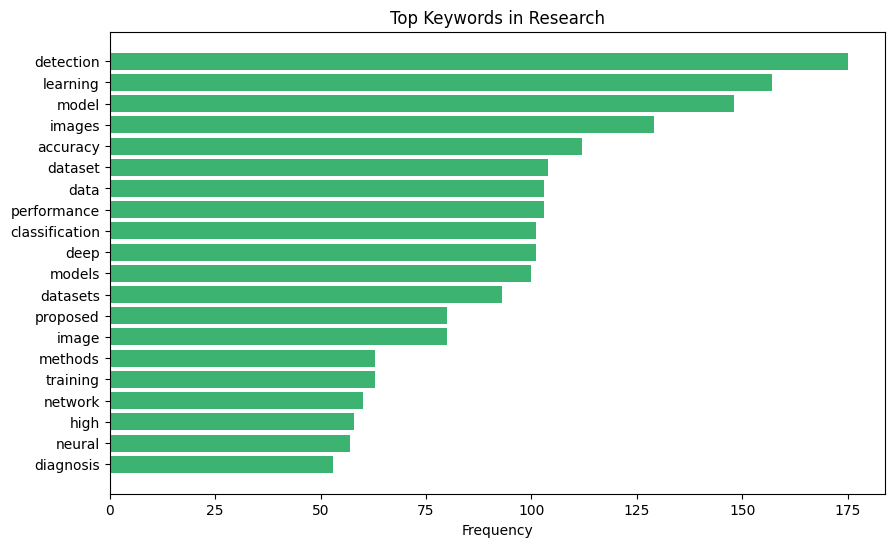

In [84]:
all_words = " ".join(df["clean_abstract"]).split()
counter = Counter(all_words)
common = counter.most_common(20)

words, counts = zip(*common)

plt.figure(figsize=(10,6))
plt.barh(words[::-1], counts[::-1], color="mediumseagreen")
plt.title("Top Keywords in Research")
plt.xlabel("Frequency")
plt.show()


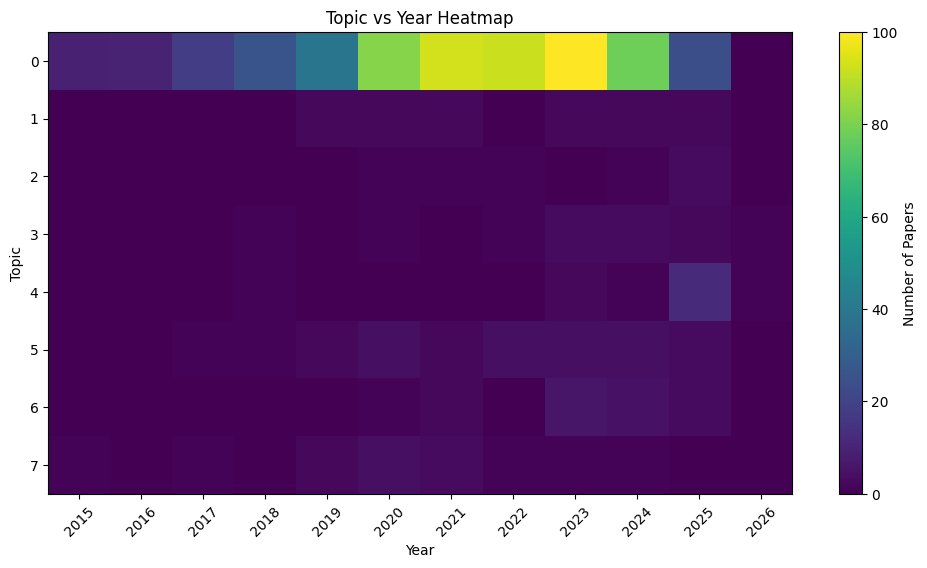

In [85]:
pivot = pd.pivot_table(
    df,
    values="title",
    index="topic",
    columns="year",
    aggfunc="count",
    fill_value=0
)

plt.figure(figsize=(12,6))
plt.imshow(pivot, aspect="auto", cmap="viridis")
plt.colorbar(label="Number of Papers")
plt.xlabel("Year")
plt.ylabel("Topic")
plt.title("Topic vs Year Heatmap")
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=45)
plt.yticks(range(len(pivot.index)), pivot.index)
plt.show()
